In [1]:
%matplotlib inline
%load_ext Cython

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pandas as pd
from pathlib import Path
from os.path import join
import re
from glob import glob

import platform

if platform.system() == 'Darwin':
    %config InlineBackend.figure_format = 'retina'


sns.set()
sns.set_palette('colorblind');

In [2]:
def read_csvx(path, *args, **kwargs):
    try:
        return pd.read_csv(str(path) +'.gz', *args, **kwargs)
    except Exception as e:
        return pd.read_csv(str(path), *args, **kwargs)

/data/logs/bm-iter-test-2019-01-17/canonical_bm_tp/cmaes/20000/run_09/rep00/
fail because of File b'/data/logs/bm-iter-test-2019-01-17/canonical_bm_tp/cmaes/20000/run_09/rep00/../fit.txt' does not exist


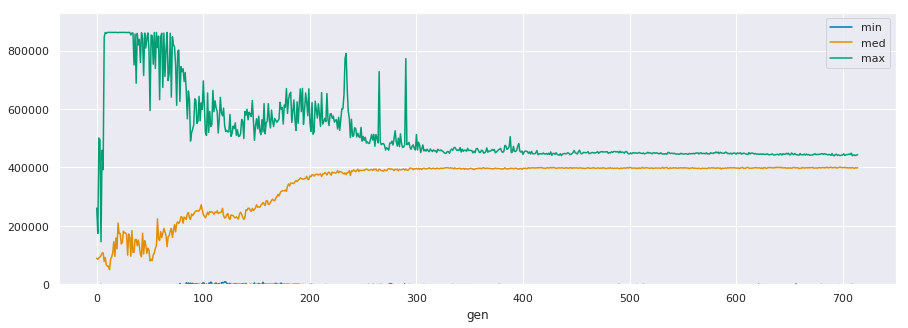

gen: 499


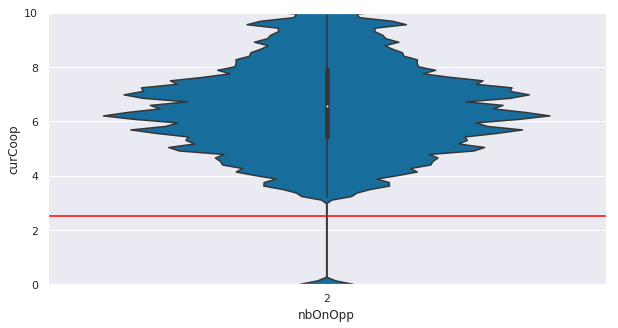

/home/pecoffet/miniconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/pecoffet/miniconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


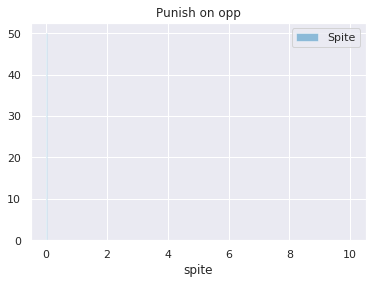

6.74901230666474


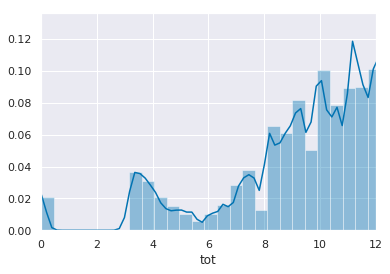

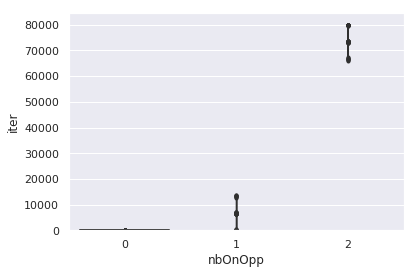

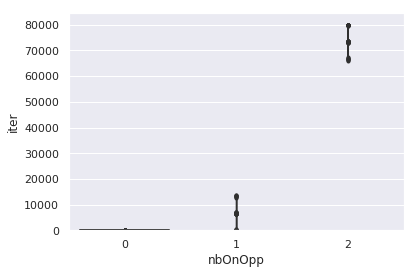

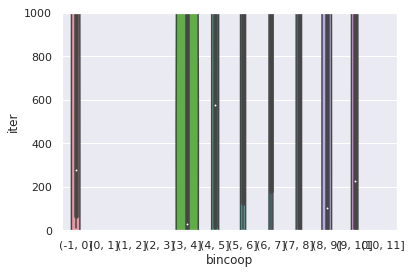

In [4]:

#gens = [1499, 1999, 2499, 2999]
gens = [0]
conds = sorted(list(glob("/data/logs/bm-iter-test-2019-01-*/canonical_bm_tp/cmaes/20000/run_09/rep00/", recursive=True)))
#conds = ['/data/logs/trash/oldschoolbm_rarereward/rep00/', '/data/logs/trash/oldschoolbm_rarereward2/rep00']

#conds = ['/data/logs/trash/oldschool_rewardwhendisappear/rep00/', '/data/logs/trash/oldschool_rewardwhendisappear2/rep00']
#conds = ['/data/logs/trash/oldschool_rewardwhendisappear2_fast/rep00', '/data/logs/trash/oldschool_rewardwhendisappear2_slow/rep00']


for cond in conds:
    print(cond)
    try:
        fitpath = Path(cond) / "../fit.txt"
        fit = read_csvx(fitpath, delimiter='\t', names=['gen', 'min', 'q1', 'med', 'q3', 'max'])
    except Exception as e:
        print('fail because of', e)
        fitpath = Path(cond) / "fitnesslog.txt"
        fit = read_csvx(fitpath, delimiter='\t')
        fitsum = fit.groupby(['gen', 'ind']).sum()
        fitgen = fit.groupby(['gen'])
        fit = pd.DataFrame()
        fit['min'] = fitgen['fitness'].min()
        fit['max'] = fitgen['fitness'].max()
        fit['med'] = fitgen['fitness'].median()
        
        
    fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))
    fit.plot(y='min', ax=ax1)
    fit.plot(y='med', ax=ax1)
    fit.plot(y='max', ax=ax1)
    ax1.set_ylim(-10, None)
    plt.show(fig)

    for gen in gens:
        if gen == 0:
            gen = max([int(re.search('logall_(\d+)', fname).group(1)) for fname in glob(join(cond, 'logall_*'))])
        logfile = join(cond, 'logall_{}.txt'.format(gen))
        i = 0
        ok = True
        to_format = '{' in logfile
        logs = []
        while ok:
            try:
                dat = read_csvx(logfile.format(i), delimiter="\t")
                dat["eval"] = i
                logs.append(dat)
            except:
                ok = False
            else:
                i += 1
                ok = to_format
        try:
            log = pd.concat(logs).copy() # Fakes are removed from data
        except Exception as e:
            plt.show(fig)
            print(e)
            print("no data, continue")
            continue
        print("gen:", gen)
        fig, ax2 = plt.subplots(1, 1, figsize=(10, 5))
        try:
            sns.violinplot(data=log.query('2 <= nbOnOpp and oppId != -1'), x='nbOnOpp', y='curCoop', ax=ax2, cut=0)
            ax2.axhline(2.5, color="red")
            ax2.set_ylim(0, 10)
            plt.show(fig)
        except Exception as e:
            print(type(e), ':', e)
            print('No one played')

        try:
            fig, ax1 = plt.subplots(1,1, sharex=True)
            ax = ax1
            on_opp = log.query('oppId != -1').copy()
            sns.distplot(on_opp['spite'], label="Spite", ax=ax)
            ax.set_xlim(-0.5, 10.5)
            #sns.distplot(on_opp['a'], label="ess")
            ax.legend()
            ax.set_title('Punish on opp')
            plt.show(fig)
            print(on_opp['curCoop'].mean())

            fig, ax = plt.subplots()
        except:
            print("no spite for this run")
        
        on_opp['tot'] = on_opp['meanTotal'] + on_opp['curCoop']
        
        sns.distplot(on_opp['tot'].dropna(), ax=ax)
        ax.set_xlim(0, 12)
        plt.show(fig)
        
        
        fig, ax = plt.subplots()
        sns.violinplot(data=log.groupby(['id', 'nbOnOpp'], as_index=False).count(), x='nbOnOpp', y='iter', ax=ax, cut=0, inner='points')
        ax.set_ylim((0, None))
        plt.show()
        
        fig, ax = plt.subplots()
        sns.violinplot(data=log.groupby(['id', 'nbOnOpp'], as_index=False).count(), x='nbOnOpp', y='iter', ax=ax, cut=0, inner='points')
        ax.set_ylim((0, None))
        plt.show()
        
        fig, ax = plt.subplots()
        log['bincoop'] = pd.cut(log['meanTotal'], bins=list(range(-1, 12)))
        spenttime = log.query('oppId != -1').groupby(['bincoop', 'id'], as_index=False)['iter'].count()
        sns.violinplot(x='bincoop', y='iter', data=spenttime, ax=ax)
        plt.ylim(0, 1000)
        plt.show(fig)

# Fast coop read from genome

Text(0.5,1,"niveau d'investissement de tous les agents pour nfix, teleportation, fit, d'après le génome")

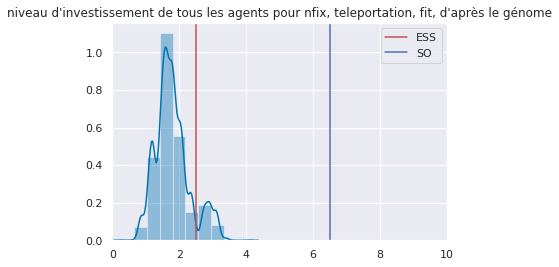

In [152]:
import json

gen = 499
conds = sorted(list(glob(f'/data/logs/bm-fit-nfix-notp-norep-2019-01-09-1437/**/rep00', recursive=True)))
#conds = ['/data/logs/trash/oldschoolbm_rarereward/rep00/', '/data/logs/trash/oldschoolbm_rarereward2/rep00']

#conds = ['/data/logs/trash/oldschool_rewardwhendisappear/rep00/', '/data/logs/trash/oldschool_rewardwhendisappear2/rep00']
#conds = ['/data/logs/trash/oldschool_rewardwhendisappear2_fast/rep00', '/data/logs/trash/oldschool_rewardwhendisappear2_slow/rep00']

means = np.array([], dtype=float)
for cond in conds:
    with open(cond + f'/genomes_{gen}.txt') as f:
        dat = np.asarray(json.load(f))
    means = np.concatenate((means, dat[:, 0] * 10))

sns.distplot(means, bins=10)
plt.axvline(2.5, label="ESS", c="r")
plt.axvline(6.5, label="SO", c="b")
plt.legend()
plt.xlim(0, 10)
plt.title('niveau d\'investissement de tous les agents pour nfix, teleportation, fit, d\'après le génome')

In [32]:
log['bincoop'] = pd.cut(log['meanTotal'], bins=list(range(-1, 12)))

In [ ]:
spenttime = log.query('onOpp != -1').groupby(['bincoop', 'id'], as_index=False)['iter'].count()

sns.violinplot(x='bincoop', y='iter', data=spenttime)
plt.ylim(0, 1000)

In [6]:
gens = range(249, 18000, 250)
cond = "/data/logs/s2700-see-tp-2018-09-24-1739/canonical_bm_tp/run_12/rep{:02}/"
cond = "/data/logs/s2700-see-tp-2018-09-26-1444/canonical_bm_tp/run_2/rep{:02}/"
logs = []
for gen in gens:
        logfile = join(cond, f'logall_{gen}.txt')
        i = 0
        ok = True
        to_format = '{' in logfile
        while ok:
            try:
                dat = read_csvx(logfile.format(i), delimiter="\t").query('fake == 0').copy()
                dat["eval"] = i
                dat["gen"] = gen
                on_opp = dat.query('onOpp == 1 and nbOnOpp == 2').copy()
                on_opp['bin'] = pd.cut(on_opp['curCoop'], np.arange(0, 10.1, 0.5))
                counts = on_opp.groupby(['bin', 'gen'], as_index=False)['curCoop'].count()
                counts['curCoop'] /= np.max(counts.curCoop)
                logs.append(counts)
            except FileNotFoundError as e:
                ok = False
            else:
                i += 1
                ok = to_format
print(len(logs))

180


In [5]:
#time_spent_searching = log
log['notOnOpp'] = np.where(log['oppId'] == -1, 1, 0)
log['onOpp'] = np.where(log['oppId'] != -1, 1, 0)

In [6]:
%%cython
cimport cython
cimport numpy as np
import pandas as pd
import numpy as np

def seqsize(np.ndarray array):
    cdef int start = -1
    cdef int i = 0
    cdef np.ndarray out = np.zeros(len(array)) * np.nan
    for elem in array:
        if elem == 1 and start == -1:
            start = i
        elif elem == 0 and start != -1:
            out[start:i] = i - start
            start = -1
        i += 1
    if start != -1:
        out[start:i] = i - start
    return out

def todf(x):
    return pd.DataFrame({'iter': np.arange(len(x)), 'wait': seqsize(np.array(x))})

In [7]:
wait = log.groupby(['id', 'eval'])['notOnOpp'].apply((lambda x : np.nanmean(seqsize(np.array(x)))))
stay = log.groupby(['id', 'eval'])['onOpp'].apply((lambda x : np.nanmean(seqsize(np.array(x)))))

26099.142504343894

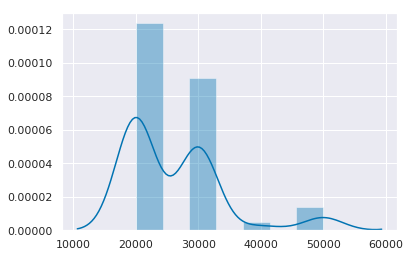

In [8]:
beta = 1/wait # Change to is same object for measurement with TP
tau = 1/stay

sns.distplot(beta/tau)
(beta/tau).mean()

In [14]:
log.query('id == 1')

,eval,iter,id,a,fakeCoef,oppId,nbOnOpp,curCoop,meanOwn,meanTotal,punish,spite,bincoop,notOnOpp,onOpp
1,0,0,1,5,1.252460,-1,0,8.20413,5.88010,5.84600,0,0,"(5, 6]",1,0
101,0,1,1,5,1.252460,4,2,8.20413,0.00000,0.00000,0,0,"(-1, 0]",0,1
201,0,2,1,5,1.252460,22,2,8.20413,0.00000,0.00000,0,0,"(-1, 0]",0,1
301,0,3,1,5,1.252460,25,1,8.20413,8.20413,0.00000,0,0,"(-1, 0]",0,1
401,0,4,1,5,1.252460,0,2,8.20413,8.20413,6.87246,0,0,"(6, 7]",0,1
501,0,5,1,5,1.252460,64,2,8.20413,8.20413,6.25630,0,0,"(6, 7]",0,1
601,0,6,1,5,1.252460,13,1,8.20413,8.20413,0.00000,0,0,"(-1, 0]",0,1
701,0,7,1,5,1.252460,53,2,8.20413,8.20413,5.85051,0,0,"(5, 6]",0,1
801,0,8,1,5,1.252460,39,1,8.20413,8.20413,0.00000,0,0,"(-1, 0]",0,1
901,0,9,1,5,1.252460,50,1,8.20413,8.20413,0.00000,0,0,"(-1, 0]",0,1


(0, 0.3)

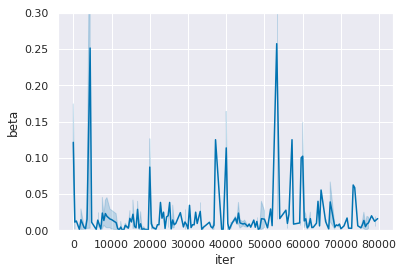

In [122]:
res['beta'] = 1 / res['wait']
sns.lineplot(x='iter', y='beta', data=res.query('iter % 400 == 0'))
plt.ylim(0, 0.3)

In [8]:
pc = pd.pivot_table(data=log, columns='gen', index='bin')
pc[pd.isna(pc)] = 0

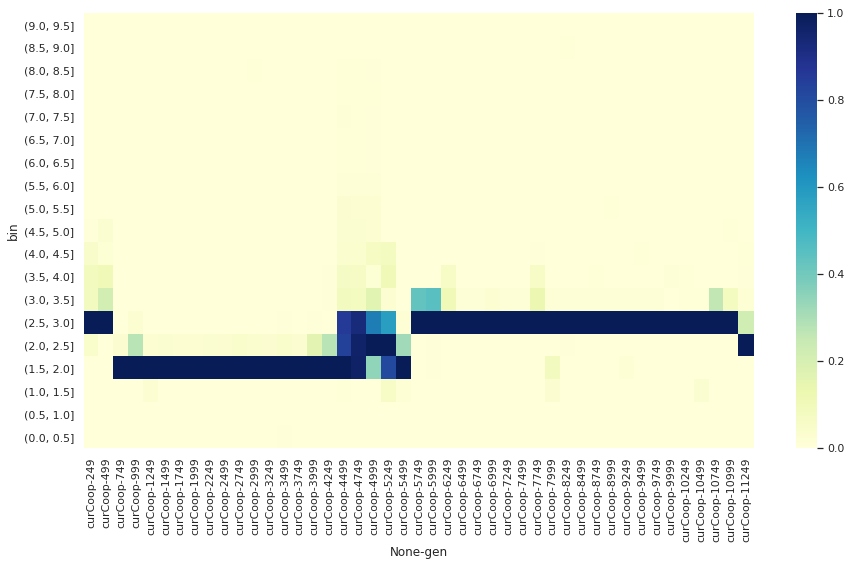

In [9]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(data=pc, vmin=0, vmax=1, cmap="YlGnBu", ax=ax)
ax.invert_yaxis()

In [15]:
gens = [1499, 2499, 2]
logs = []

for gen in gens:
    logfile = join(cond, f'logall_{gen}.txt')
    i = 0
    ok = True
    to_format = '{' in logfile
    while ok:
        try:
            dat = read_csvx(logfile.format(i), delimiter="\t")
            dat["eval"] = i
            dat["gen"] = gen
            logs.append(dat)
        except:
            ok = False
        else:
            i += 1
            ok = to_format
log = pd.concat(logs).query('fake == 0').copy() # Fakes are removed from data
fig, ax = plt.subplots()
sns.violinplot(data=log.groupby(['id', 'nbOnOpp', 'gen'], as_index=False).count(), x='nbOnOpp', y='iter', ax=ax, cut=0, inner='points', hue='gen')
plt.show()

fail with gz, trying without for /data/logs/trash/test_no_see_split/rep00/logall_1499.txt
fail with gz, trying without for /data/logs/trash/test_no_see_split/rep00/logall_2499.txt
fail with gz, trying without for /data/logs/trash/test_no_see_split/rep00/logall_2.txt


ValueError: No objects to concatenate

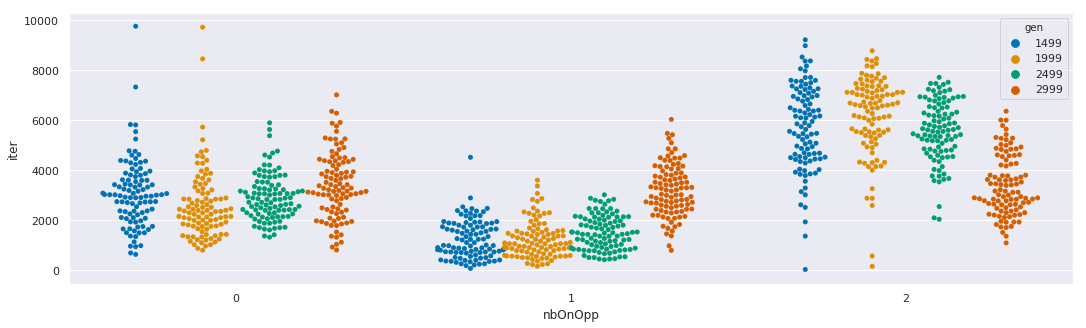

In [38]:
fig, ax = plt.subplots(figsize=(18, 5))
sns.swarmplot(data=log.groupby(['id', 'nbOnOpp', 'gen'], as_index=False).count(), x='nbOnOpp', y='iter', ax=ax, hue='gen', dodge=True)
plt.show()

In [ ]:
print(scipy.stats.normaltest(on_opp['curCoop']))
print(scipy.stats.normaltest(on_opp['a']))

Not normal, so wilcoxon

In [5]:
scipy.stats.wilcoxon(on_opp['curCoop'], on_opp['a']/on_opp['nbOnOpp'])

NameError: name 'on_opp' is not defined

In [6]:
on_opp['curCoop'].median(), (on_opp['a']/on_opp['nbOnOpp']).median()

NameError: name 'on_opp' is not defined

In [7]:
try: 
    sns.distplot(log.groupby('id').mean()['a'])
except:
    print("a ne varie pas")

a ne varie pas


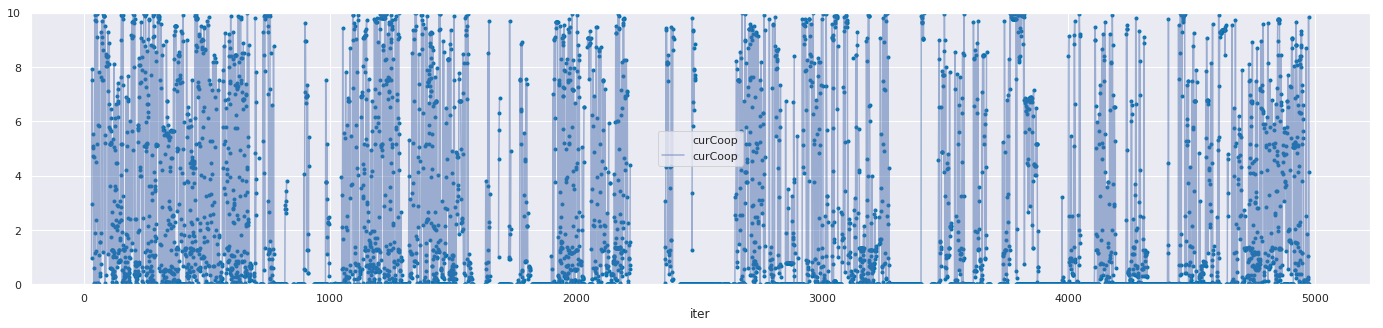

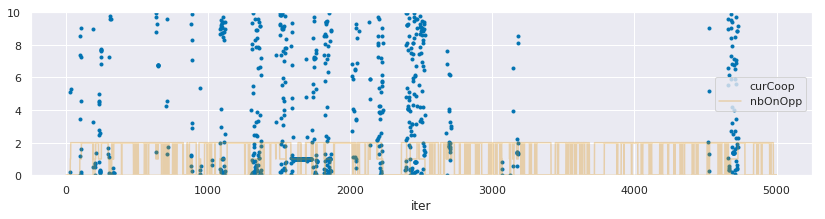

In [5]:
beg = 0
end = 5000
ind = 0
fig = plt.figure(figsize=(24,5))
ax = fig.gca()
nlog = log.query('fake == 0').copy()
nlog['curCoop'] = np.where(nlog['nbOnOpp'] == 2, nlog['curCoop'], np.nan)
nlog.query('id == {}'.format(ind)).plot(x='iter', y='curCoop', ax=ax, style='.')
nlog.query('id == {}'.format(ind)).plot(x='iter', y='curCoop', ax=ax, style='-', c='b', alpha=0.5)
#nlog.query('id == {}'.format(ind)).plot(alpha=0.3, x='iter', y='nbOnOpp', ax=ax)
ax.set_ylim(0, 10)

fig = plt.figure(figsize=(14,3))
ax = fig.gca()
nlog = log.copy()
nlog['curCoop'] = np.where(nlog['nbOnOpp'] == 1, nlog['curCoop'], np.nan)
nlog.query('id == {}'.format(ind)).plot(x='iter', y='curCoop', ax=ax, style='.')
nlog.query('id == {}'.format(ind)).plot(alpha=0.3, x='iter', y='nbOnOpp', ax=ax)
ax.set_ylim(0, 10);

In [9]:
%%script false 
c = 1
defforgive = 0
forgive = defforgive
log['step'] = np.nan
for e in log['eval'].unique():
    for j in log['id'].unique():
        for i, elem in log.query(f'id == {j} and eval == {e}').iterrows():
            if elem['onOpp'] == 1:
                if elem['nbOnOpp'] >= 2:
                    log.at[i, 'step'] = c
                    c += 1
                    forgive = defforgive
                else:
                    forgive -= 1
                    if forgive > 0 and c > 1:
                        log.at[i, 'step'] = c
                        c += 1
                        print("forgiven")
                    else:
                        c = 1
                        forgive = defforgive
            else:
                c = 1
                forgive = defforgive
        c=1
        forgive = defforgive

In [ ]:
fig = plt.figure()
ax = fig.gca()
sns.distplot(log.query('step > 40 and nbOnOpp == 2')['curCoop'], ax=ax)
ax.set_xlim(0, 10)

fig = plt.figure()
ax = fig.gca()
sns.distplot(log.query('step >= 0 and nbOnOpp == 2')['curCoop'], ax=ax)
ax.set_xlim(0, 10)


In [123]:
log.groupby('step').mean().plot(y='curCoop')

KeyError: 'step'

In [140]:
log.query('curCoop > 3 and nbOnOpp == 2')

,eval,iter,id,a,onOpp,nbOnOpp,curCoop,meanOwn,meanTotal
283,0,9,13,5,1,2,4.01307,4.01307,5.03242
332,0,11,2,5,1,2,3.76133,2.39883,2.88289
362,0,12,2,5,1,2,3.19235,2.66334,3.04648
392,0,13,2,5,1,2,3.44265,2.85817,3.18960
414,0,13,24,5,1,2,4.49956,4.54894,4.58513
422,0,14,2,5,1,2,3.59677,3.00589,3.29687
452,0,15,2,5,1,2,3.71399,3.12390,3.41688
482,0,16,2,5,1,2,3.75964,3.21472,3.50742
502,0,16,22,5,1,2,3.85873,3.85873,8.28744
503,0,16,23,5,1,2,4.42872,4.44664,5.73288


/home/pecoffet/miniconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


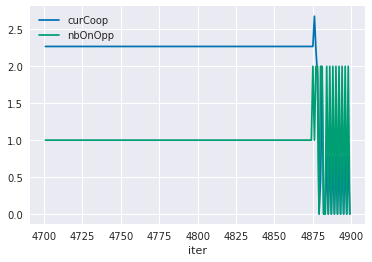

In [141]:
log.query(f'eval == 0 and 4700 < iter < 4900 and id == 3').plot(x='iter', y=['curCoop', 'nbOnOpp'])


In [142]:
def p(invest, totalInvest, a, n):
    b = 1
    return (a * totalInvest + b * (totalInvest - invest)) / n - 0.5 * invest * invest

1.3332743691034283

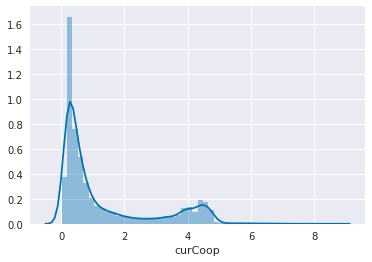

In [143]:
curcoop = log.query('nbOnOpp == 2')['curCoop']
meantot = log.query('nbOnOpp == 2')['meanTotal']
a = log.query('nbOnOpp == 2')['a']
n = log.query('nbOnOpp == 2')['nbOnOpp']
sns.distplot(curcoop)
curcoop.mean()

In [144]:
cur = p(curcoop, meantot, a, n).sum()
cur

333052.50806842686

In [145]:
opti = p(a/n, meantot - curcoop + a/n, a, n).sum()
opti

443171.05738315

In [146]:
(cur - opti) / opti

-0.24847865734949953